# SCAN ROI Functional Connectivity by Sleep Stage

In [1]:
# misc directory is at the same level as scan directory, 
# so we need to change the current working directory to the root directory
# ONLY RUN THIS CELL ONCE

import os
os.chdir(os.path.dirname(os.getcwd()))

## Load Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from scan.io.load import DatasetLoad
from scan.model.fc import FCModulation


from main import (
    _concat_bootstrap_samples, 
    _generate_bootstrap_samples, 
    LH_ROI_MASKS,
    RH_ROI_MASKS
)

# load functional connectivity data
loader = DatasetLoad(
    'vanderbilt'
)
data, _ = loader.load(
    physio_high_pass=True, 
    func_high_pass=True,
    concat=False,
    input_mask=True,
    lh_roi_masks=LH_ROI_MASKS,
    rh_roi_masks=RH_ROI_MASKS
)

# load sleep stages
sleep_stages_all = []
for subj_ses in loader.iter:
    sleep_fp = f"data/vanderbilt/sleep/vcon{subj_ses[0]}-scan{subj_ses[1]}_eeg_vsleep.mat"
    sleep_data = loadmat(sleep_fp, squeeze_me=True)
    sleep_stages = sleep_data['b_vsleep_bin_ds']
    # trim first 7 volumes to match functional data
    sleep_stages = sleep_stages[7:]
    sleep_stages_all.append(sleep_stages)

# assign to data returned from iterator
data['sleep'] = sleep_stages_all

/Users/taylorbolt/opt/miniconda3/envs/scan/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loading scan: subj: 03 ses: 01
loading scan: subj: 04 ses: 02
loading scan: subj: 04 ses: 02
loading scan: subj: 05 ses: 01
loading scan: subj: 05 ses: 01
loading scan: subj: 07 ses: 01
loading scan: subj: 07 ses: 01
loading scan: subj: 08 ses: 01
loading scan: subj: 08 ses: 01
loading scan: subj: 09 ses: 01
loading scan: subj: 09 ses: 01
loading scan: subj: 09 ses: 02
loading scan: subj: 09 ses: 02
loading scan: subj: 10 ses: 01
loading scan: subj: 10 ses: 01
loading scan: subj: 10 ses: 02
loading scan: subj: 10 ses: 02
loading scan: subj: 13 ses: 01
loading scan: subj: 13 ses: 01
loading scan: subj: 14 ses: 01
loading scan: subj: 14 ses: 01
loading scan: subj: 14 ses: 02
loading scan: subj: 14 ses: 02
loading scan: subj: 15 ses: 02
loading scan: subj: 15 ses: 02
loading scan: subj: 18 ses: 01
loading scan: subj: 18 ses: 01
loading scan: subj: 18 ses: 02
loading scan: subj: 18 ses: 02
loading scan: subj: 19 ses: 02
loading scan: subj: 19 ses: 02
loading scan: subj: 20 ses: 01
loading 

## Functional Connectivity By Sleep Stage

In [ ]:
roi_labels = [
    'bottom_left',
    'middle_left',
    'top_left',
    'bottom_right',
    'middle_right',
    'top_right'
]

# create bootstrapped samples
subject_session_list = list(loader.iter)
bootstrap_samples = _generate_bootstrap_samples(subject_session_list)
fc_stage_samples = []

# loop through bootstrap samples
for i, sample in enumerate(bootstrap_samples):
    if i % 100 == 0:
        print(f'Bootstrap sample {i+1} of {len(bootstrap_samples)}')
    # concatenate data from sample
    func_sample = _concat_bootstrap_samples(
        sample, subject_session_list, {'func': data['func']}
    )
    sleep_sample = _concat_bootstrap_samples(
        sample, subject_session_list, {'sleep': data['sleep']}
    )
    # loop through ROIs and calculate FC by sleep stage
    fc_stage_rois = []
    for i in range(len(roi_labels)):
        fc = FCModulation(sleep_sample['sleep'])
        fc_res = fc.estimate_fc_modulation(
            func_sample['func'][:,i], np.delete(func_sample['func'], i, axis=1)
        )
        fc_stage_rois.append(fc_res.fc_stages)
    fc_stage_samples.append(fc_stage_rois)

# loop through sleep stages and calculate mean fc for all ROI pairs
fc_stages_mean = []
fc_stages_std = []
for i in range(3):
    fc_stages_mean.append(
        [
            np.mean([fc_stage_samples[j][r][i] for j in range(len(fc_stage_samples))], axis=0) 
            for r in range(len(roi_labels))
        ]
    )
    fc_stages_std.append(
        [
            np.std([fc_stage_samples[j][r][i] for j in range(len(fc_stage_samples))], axis=0)
            for r in range(len(roi_labels))
        ]
    )


Bootstrap sample 1 of 1000
18176
18176
Bootstrap sample 101 of 1000
17040
17040
Bootstrap sample 101 of 1000
17040
17040
Bootstrap sample 201 of 1000
19312
19312
Bootstrap sample 201 of 1000
19312
19312
Bootstrap sample 301 of 1000
15904
15904
Bootstrap sample 301 of 1000
15904
15904
Bootstrap sample 401 of 1000
17040
17040
Bootstrap sample 401 of 1000
17040
17040
Bootstrap sample 501 of 1000
17040
17040
Bootstrap sample 501 of 1000
17040
17040
Bootstrap sample 601 of 1000
14200
14200
Bootstrap sample 601 of 1000
14200
14200
Bootstrap sample 701 of 1000
18176
18176
Bootstrap sample 701 of 1000
18176
18176
Bootstrap sample 801 of 1000
18176
18176
Bootstrap sample 801 of 1000
18176
18176
Bootstrap sample 901 of 1000
17040
17040
Bootstrap sample 901 of 1000
17040
17040


In [35]:
np.percentile([[fc_stage_samples[j][0][2] for j in range(len(fc_stage_samples))]], 2.5, axis=1)

array([[[0.6830732 ],
        [0.5683274 ],
        [0.74710499],
        [0.55184471],
        [0.56976833]]])

In [52]:
np.percentile([[fc_stage_samples[j][0][0] for j in range(len(fc_stage_samples))]], 97.5, axis=1)

array([[[0.69148649],
        [0.63774576],
        [0.77360839],
        [0.66922774],
        [0.598467  ]]])

In [63]:
sleep_stages_all_c = [np.where(s == -2, -1, s) for s in sleep_stages_all]

In [ ]:
np.unique([len(np.unique(s)) for s in sleep_stages_all_c], return_counts=True)

31

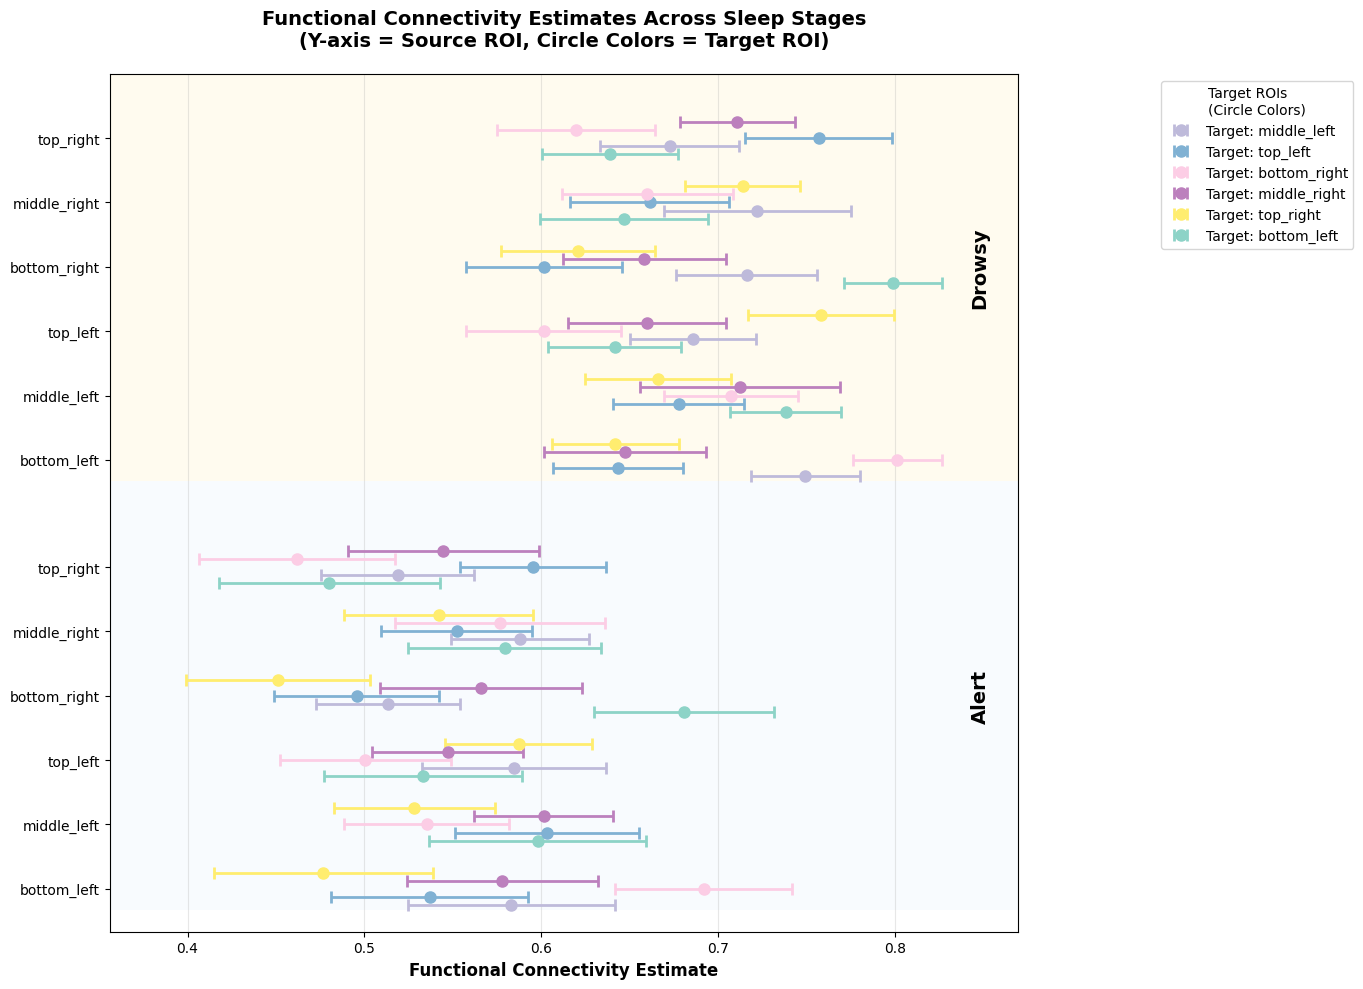

In [59]:
%matplotlib inline
# Final version with constant systematic spacing: Clean and predictable visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Sleep stage labels and colors
sleep_stage_labels = ['Alert', 'Drowsy']
sleep_stage_colors = ['#e8f4fd', '#fff2cc']  # Light blue, light yellow, light orange

# Create colors for target ROIs (these will be consistent across all plots)
target_roi_colors = plt.cm.Set3(np.linspace(0, 1, len(roi_labels)))

# Calculate positions
stages = [0, 2]
n_stages = 2
n_rois = len(roi_labels)
roi_height = 1.5  # Height allocated to each ROI within a stage
stage_height = n_rois * roi_height + 1  # Height of each stage section (with spacing)
total_height = n_stages * stage_height

# Create y-positions for each ROI in each stage
y_positions = []
for stage in range(n_stages):
    stage_base = stage * stage_height + 0.5  # Start position for this stage
    for roi in range(n_rois):
        y_pos = stage_base + roi * roi_height
        y_positions.append(y_pos)

# First, find the overall range of FC values for consistent x-axis
all_fc_values = []
for stage in stages:
    for roi in range(n_rois):
        fc_mean = np.array(fc_stages_mean[stage][roi])
        fc_std = np.array(fc_stages_std[stage][roi])
        
        # Handle the case where fc_std might be 2D - flatten if needed
        if fc_std.ndim > 1:
            fc_std = fc_std.flatten()
        if fc_mean.ndim > 1:
            fc_mean = fc_mean.flatten()
            
        # Collect all FC values including confidence intervals
        all_fc_values.extend(fc_mean)
        all_fc_values.extend(fc_mean - fc_std)  # Lower bound
        all_fc_values.extend(fc_mean + fc_std)  # Upper bound

fc_min, fc_max = min(all_fc_values), max(all_fc_values)
fc_range = fc_max - fc_min
fc_margin = fc_range * 0.1  # 10% margin

# Draw background rectangles for each sleep stage
for stage in range(n_stages):
    stage_bottom = stage * stage_height
    stage_top = (stage + 1) * stage_height
    ax.axhspan(stage_bottom, stage_top, facecolor=sleep_stage_colors[stage], alpha=0.3, zorder=0)

# Constant spacing parameters
spacing_strength = 0.5  # Total vertical spacing range for points within each ROI
n_targets_per_roi = n_rois - 1  # Number of target connections per source ROI

# Plot the data with constant systematic spacing
for stage in range(n_stages):
    for roi in range(n_rois):  # source ROI
        y_pos = stage * n_rois + roi
        actual_y = y_positions[y_pos]
        
        # Get FC data for this source ROI and stage
        fc_mean = np.array(fc_stages_mean[stages[stage]][roi])
        fc_std = np.array(fc_stages_std[stages[stage]][roi])
        
        # Handle the case where fc_std might be 2D - flatten if needed
        if fc_std.ndim > 1:
            fc_std = fc_std.flatten()
        if fc_mean.ndim > 1:
            fc_mean = fc_mean.flatten()
            
        # Get target ROIs (excluding self-connection)
        target_rois = [i for i in range(n_rois) if i != roi]
        
        # Generate constant spacing for this source ROI's points
        # Evenly distribute points vertically around the center y-position
        if n_targets_per_roi > 1:
            spacing_values = np.linspace(-spacing_strength * roi_height / 2, 
                                       spacing_strength * roi_height / 2, 
                                       n_targets_per_roi)
        else:
            spacing_values = [0]  # If only one target, no spacing needed
        
        # Plot all FC estimates for this source ROI with constant spacing
        # Each circle represents FC between this source ROI and one target ROI
        for i, target_roi in enumerate(target_rois):
            spaced_y = actual_y + spacing_values[i]
            # only display labels for one stage
            if ((stage == 0) & (roi == 0)) | (roi == 1 and stage == 1 and target_roi == 0):
                label = f'Target: {roi_labels[target_roi]}'
            else:
                label = None
            ax.errorbar(fc_mean[i], spaced_y,
                       xerr=fc_std[i], fmt='o',
                       color=target_roi_colors[target_roi], markersize=8,
                       capsize=4, capthick=2, elinewidth=2,
                       label=label)  # Only label once per target ROI

# Customize the plot
ax.set_xlim(fc_min - fc_margin, fc_max + fc_margin)
ax.set_ylim(-0.5, total_height - 0.5)

# Set x-axis
ax.set_xlabel('Functional Connectivity Estimate', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Set y-axis with source ROI labels for each stage
y_tick_positions = []
y_tick_labels = []
for stage in range(n_stages):
    for roi in range(n_rois):
        y_pos = stage * n_rois + roi
        actual_y = y_positions[y_pos]
        y_tick_positions.append(actual_y)
        y_tick_labels.append(f'{roi_labels[roi]}')

ax.set_yticks(y_tick_positions)
ax.set_yticklabels(y_tick_labels)

# Add stage labels on the right side
for stage in range(n_stages):
    stage_center = stage * stage_height + stage_height/2
    ax.text(fc_max + fc_margin * 0.5, stage_center, sleep_stage_labels[stage], 
           rotation=90, ha='center', va='center', 
           fontsize=14, fontweight='bold')

# Add legend
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', title='Target ROIs\n(Circle Colors)')

# Add title
plt.title('Functional Connectivity Estimates Across Sleep Stages\n(Y-axis = Source ROI, Circle Colors = Target ROI)', 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()